<a href="https://colab.research.google.com/github/AnnetVasileva/machineLearning/blob/main/Practical%202/Model_NN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import numpy as np
import pandas as pd
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Functions

In [59]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  auc_score = sklearn.metrics.roc_auc_score(labels, predictions)
  line_name =  name+ ', AUC: ' + str(round(auc_score,4))
  plt.plot(100*fp, 100*tp, label= line_name,
           linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  #plt.plot([0, 100], [0, 100], linestyle='--', lw=2, color='r',
  #      label='Chance', alpha=.8)
  
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [154]:
# model function
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.models.Sequential()
  model.add(keras.layers.Dense(512,input_dim=X.shape[1],  activation="tanh",  kernel_initializer="he_normal"))
  model.add(keras.layers.Dropout(rate=0.8))
  model.add(keras.layers.Dense(256, activation="tanh",  kernel_initializer="he_normal"))
  model.add(keras.layers.Dropout(rate=0.5))
  model.add(keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=tf.keras.initializers.Constant(initial_bias)))
  
  return model

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [155]:
# read in data
path = '/content/drive/MyDrive/ML_ECO/'
pickle_file = 'data_set_big.pkl'

with open(path + pickle_file, 'rb') as f:
  train_set =pickle.load(f) 

X = train_set['X']
y = train_set['y']
X.shape

(111680, 174)

In [156]:
# split to train and test
X_train_full, X_test, y_train_full, y_test = train_test_split( X, y, 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    stratify = y)
X_train_full.shape

(100512, 174)

In [157]:
# split train and valid
X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify = y_train_full)

X_train.shape

(80409, 174)

In [158]:
scaler_train = StandardScaler()
scaler_valid = StandardScaler()
scaler_test = StandardScaler()

scaler_test.fit(X_test)
scaler_train.fit(X_train)
scaler_valid.fit(X_valid)

X_train = scaler_train.transform(X_train)
X_valid = scaler_valid.transform(X_valid)
X_test = scaler_test.transform(X_test)

In [159]:
# this should make sgd to be able to varry the learning rate
# taken from keras example
first_decay_steps = 100
initial_learning_rate = 0.001
lr_decayed_fn = (
  tf.keras.experimental.CosineDecayRestarts(
      initial_learning_rate,
      first_decay_steps))
opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn)

In [161]:
#build basic model

# correct bias
total = len(y_train)
pos = y_train.sum()
neg = total - pos
initial_bias = np.log([pos/neg])

basic_model = make_model(output_bias=initial_bias)


EPOCH = 150
BATCH_SIZE = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

basic_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer= opt,
              #keras.optimizers.Adam(),
              #opt,
              metrics=METRICS)

basic_history = basic_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH,
                    callbacks=[early_stopping],
                    validation_data=(X_valid, y_valid))

Epoch 1/150
805/805 [==============================] - 7s 8ms/step - loss: 0.2815 - tp: 60.0112 - fp: 1150.2754 - tn: 38884.6725 - fn: 2154.6911 - accuracy: 0.9222 - precision: 0.0487 - recall: 0.0263 - auc: 0.5072 - val_loss: 0.2166 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19039.0000 - val_fn: 1064.0000 - val_accuracy: 0.9471 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5040
Epoch 2/150
805/805 [==============================] - 6s 8ms/step - loss: 0.2674 - tp: 36.4119 - fp: 662.9045 - tn: 37555.3908 - fn: 2094.9429 - accuracy: 0.9308 - precision: 0.0547 - recall: 0.0189 - auc: 0.5000 - val_loss: 0.2133 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19039.0000 - val_fn: 1064.0000 - val_accuracy: 0.9471 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5122
Epoch 3/150
805/805 [==============================] - 6s 8ms/step - loss: 0.2553 - tp: 18.9702 - fp: 387.0682 - tn: 37833.3412 - fn: 2110.2705 - accuracy: 0.9372 - precision: 0.0

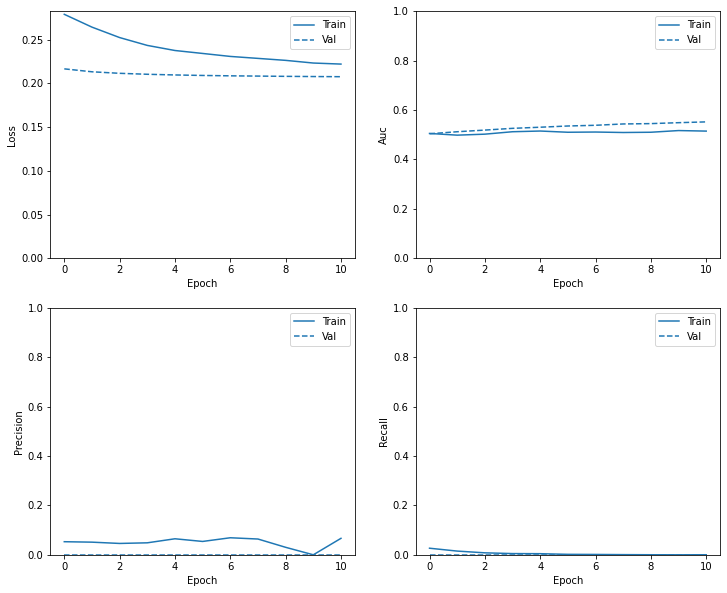

In [162]:
plot_metrics(basic_history)

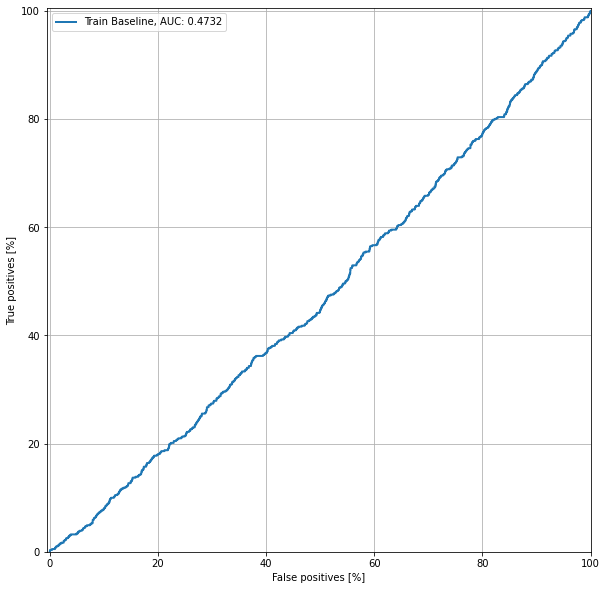

In [163]:
basic_results = basic_model.predict(X_test)
plot_roc("Train Baseline", y_test, basic_results, color=colors[0])
plt.legend()

In [164]:
basic_model.evaluate(X_test, y_test)

349/349 [==============================] - 2s 5ms/step - loss: 0.2200 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 10577.0000 - fn: 591.0000 - accuracy: 0.9471 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4734


[0.21998867392539978,
 0.0,
 0.0,
 10577.0,
 591.0,
 0.9470809698104858,
 0.0,
 0.0,
 0.47340136766433716]

In [165]:
#over sample data
#pos_features, pos_labels
pos_features = X_train[np.where(y_train==1)].copy()
pos_labels = y_train[np.where(y_train==1)].copy()

neg_features = X_train[np.where(y_train==0)].copy()
neg_labels = y_train[np.where(y_train==0)].copy()

BUFFER_SIZE = 10000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [167]:
pos_weight = 0.4
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[pos_weight, 1 - pos_weight])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

resampled_model = make_model()

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])


early_stopping_re = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

resampled_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=METRICS)

val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

EPOCHS =100

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping_re],
    validation_data=val_ds)

Epoch 1/100
1524/1524 [==============================] - 13s 8ms/step - loss: 0.7348 - tp: 8979.6518 - fp: 11140.4393 - tn: 45364.4551 - fn: 21983.3882 - accuracy: 0.6410 - precision: 0.4394 - recall: 0.3135 - auc: 0.6387 - val_loss: 0.5174 - val_tp: 287.0000 - val_fp: 3443.0000 - val_tn: 15596.0000 - val_fn: 777.0000 - val_accuracy: 0.7901 - val_precision: 0.0769 - val_recall: 0.2697 - val_auc: 0.5874
Epoch 2/100
1524/1524 [==============================] - 11s 8ms/step - loss: 0.6603 - tp: 7010.2020 - fp: 6545.1043 - tn: 39150.9049 - fn: 23593.7233 - accuracy: 0.6044 - precision: 0.5165 - recall: 0.2239 - auc: 0.5977 - val_loss: 0.5321 - val_tp: 342.0000 - val_fp: 3898.0000 - val_tn: 15141.0000 - val_fn: 722.0000 - val_accuracy: 0.7702 - val_precision: 0.0807 - val_recall: 0.3214 - val_auc: 0.5871
Epoch 3/100
1524/1524 [==============================] - 11s 7ms/step - loss: 0.6550 - tp: 8247.3003 - fp: 7352.4256 - tn: 38436.5915 - fn: 22263.6170 - accuracy: 0.6113 - precision: 0.5263

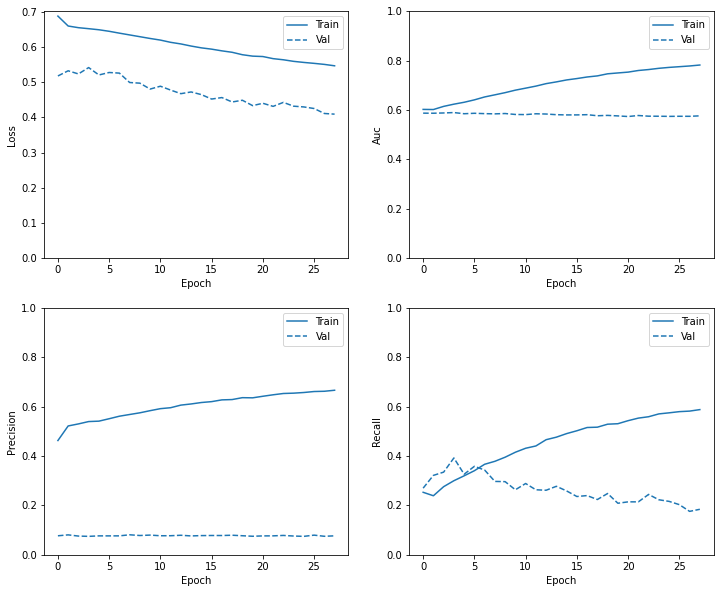

In [168]:
plot_metrics(resampled_history)

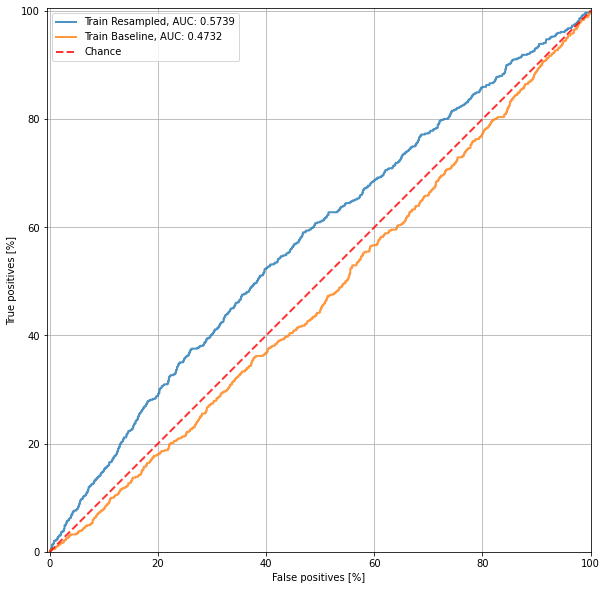

In [169]:
results_resampled = resampled_model.predict(X_test)
plot_roc("Train Resampled", y_test, results_resampled, color=colors[0], alpha = 0.8)
plot_roc("Train Baseline", y_test, basic_results, color=colors[1], alpha = 0.8)
plt.plot([0, 100], [0, 100], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)
plt.legend()

In [189]:
resampled_model.evaluate(X_test,y_test)

349/349 [==============================] - 2s 5ms/step - loss: 0.4799 - tp: 125.0000 - fp: 1491.0000 - tn: 9086.0000 - fn: 466.0000 - accuracy: 0.8248 - precision: 0.0774 - recall: 0.2115 - auc: 0.5737


[0.47991588711738586,
 125.0,
 1491.0,
 9086.0,
 466.0,
 0.8247671723365784,
 0.07735148817300797,
 0.2115059196949005,
 0.5736678242683411]

In [182]:
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
# split to train and test
X_train_full, X_test, y_train_full, y_test = train_test_split( X, y, 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    stratify = y)
X_train_full.shape
X_over, y_over = undersample.fit_resample(X_train_full, y_train_full)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [183]:
# split data
X_train, X_valid, y_train, y_valid = train_test_split( X_over, y_over, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify = y_over)

X_train.shape

(8513, 174)

In [184]:
#scale for under sampler
scaler = StandardScaler()
scaler.fit(X_train)

scaler_test = StandardScaler()
scaler_test.fit(X_test)
scaler_valid = StandardScaler()
scaler_valid.fit(X_valid)

X_train = scaler.transform(X_train)
X_valid = scaler_valid.transform(X_valid)
X_test = scaler_test.transform(X_test)

scaler_test = StandardScaler()
scaler_test.fit(X_test)
X_test = scaler_test.transform(X_test)

In [185]:
under_model = make_model()

EPOCH = 150
BATCH_SIZE = 100

early_stopping_under = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)


under_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer= keras.optimizers.Adam(lr=0.0001),
              metrics=METRICS)

under_history = under_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH,
                    callbacks=[early_stopping_under],
                    validation_data=(X_valid, y_valid))

Epoch 1/150
86/86 [==============================] - 3s 21ms/step - loss: 1.5534 - tp: 520.4023 - fp: 6869.2069 - tn: 5899.0690 - fn: 2276.1724 - accuracy: 0.4102 - precision: 0.0703 - recall: 0.2362 - auc: 0.2629 - val_loss: 1.3670 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 1063.0000 - val_fn: 1063.0000 - val_accuracy: 0.4998 - val_precision: 0.3333 - val_recall: 9.3985e-04 - val_auc: 0.5150
Epoch 2/150
86/86 [==============================] - 1s 10ms/step - loss: 1.5103 - tp: 117.0115 - fp: 100.8506 - tn: 2064.8161 - fn: 2114.1724 - accuracy: 0.4928 - precision: 0.5541 - recall: 0.0530 - auc: 0.5045 - val_loss: 1.2801 - val_tp: 18.0000 - val_fp: 16.0000 - val_tn: 1049.0000 - val_fn: 1046.0000 - val_accuracy: 0.5012 - val_precision: 0.5294 - val_recall: 0.0169 - val_auc: 0.5215
Epoch 3/150
86/86 [==============================] - 1s 9ms/step - loss: 1.4191 - tp: 147.2529 - fp: 132.0575 - tn: 2049.2989 - fn: 2068.2414 - accuracy: 0.4987 - precision: 0.5336 - recall: 0.0671 - auc: 0.53

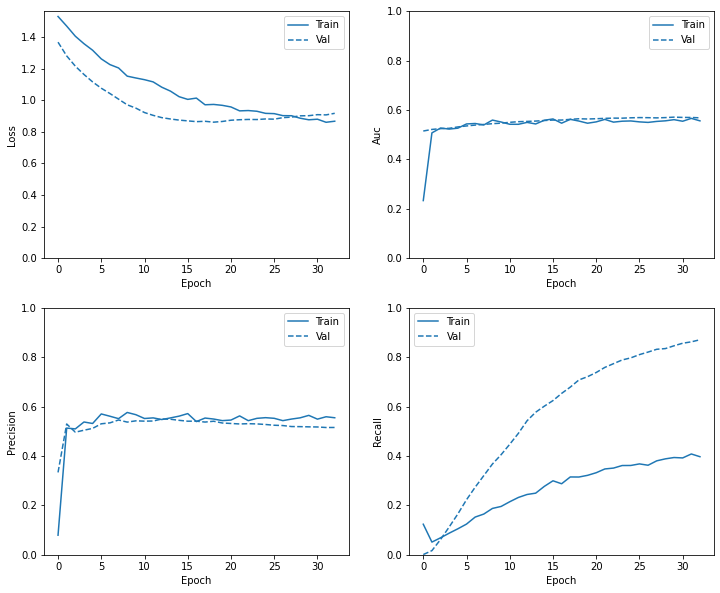

In [186]:
plot_metrics(under_history)

In [187]:
under_model.evaluate(X_test,y_test)

349/349 [==============================] - 3s 5ms/step - loss: 0.8313 - tp: 321.0000 - fp: 5153.0000 - tn: 5424.0000 - fn: 270.0000 - accuracy: 0.5144 - precision: 0.0586 - recall: 0.5431 - auc: 0.5435


[0.8312944769859314,
 321.0,
 5153.0,
 5424.0,
 270.0,
 0.5144162178039551,
 0.058640848845243454,
 0.5431472063064575,
 0.5434713959693909]

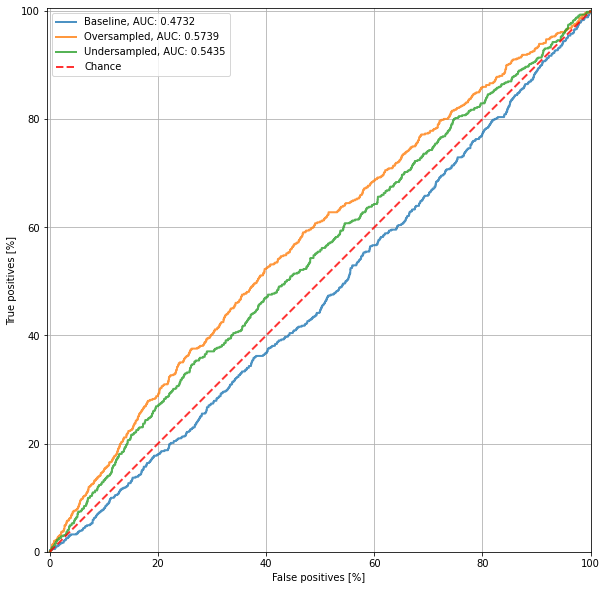

In [190]:
under_results = under_model.predict(X_test)
plot_roc("Baseline", y_test, basic_results, color=colors[0], alpha = 0.8)
plot_roc("Oversampled", y_test, results_resampled, color=colors[1], alpha = 0.8)
plot_roc("Undersampled", y_test, under_results, color=colors[2], alpha = 0.8)
plt.plot([0, 100], [0, 100], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)
plt.legend()